In [1]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from IPython.display import HTML

from astropy import units as u

from visualize_foreground import *

R_sun = 6.957e10
%matplotlib inline

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [15]:
np.where(fg_variables["p1"]<1)

(array([], dtype=int64), array([], dtype=int64))

In [8]:
np.where(fg_variables['s1']>0)

(array([  0,   0,   0, ..., 503, 503, 503]),
 array([  0,   1,   2, ..., 997, 998, 999]))

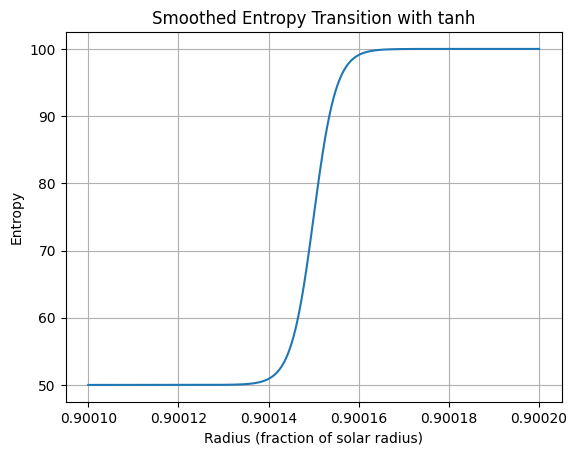

In [57]:
# Constants defined for the problem
R_SUN = 6.957e10
R_START = 0.9001
R_END = 0.9002
UPPER_ENTROPY_BOUNDARY = 100.0
LOWER_ENTROPY_BOUNDARY = 50.0

# Parameters for the tanh function
steepness = 1.0  # Increased steepness for a sharper transition
width = (R_END - R_START) * R_SUN * 0.05  # A non-zero width for transition

# Midpoint for the transition
midpoint = (R_START + (R_END - R_START) / 2.0) * R_SUN

# Linear space for radius values
z = np.linspace(R_START, R_END, 1000) * R_SUN

# tanh smoothing function
tanh_value = np.tanh(steepness * (z - midpoint) / width)

# Interpolating the entropy values with tanh smoothing
s1 = 0.5 * ((UPPER_ENTROPY_BOUNDARY - LOWER_ENTROPY_BOUNDARY) * tanh_value + UPPER_ENTROPY_BOUNDARY + LOWER_ENTROPY_BOUNDARY)

# Plotting the results
plt.plot(z / R_SUN, s1)
plt.xlabel('Radius (fraction of solar radius)')
plt.ylabel('Entropy')
plt.title('Smoothed Entropy Transition with tanh')
plt.grid(True)
plt.show()

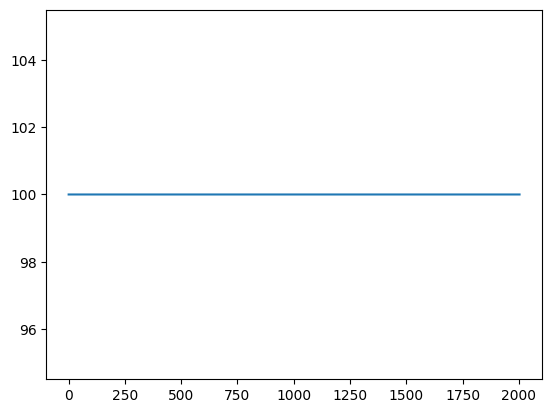

In [59]:
plt.plot(np.arange(fg_variables['s1'].shape[0]), np.mean(fg_variables['s1'], axis=1))

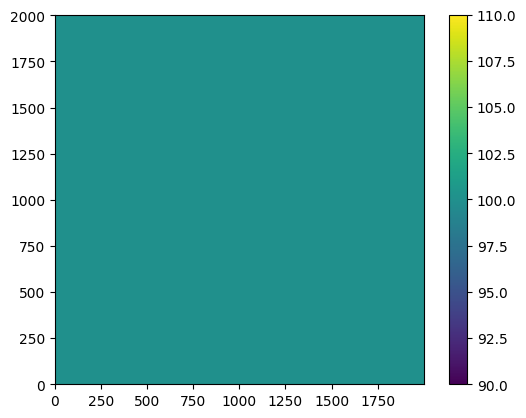

In [58]:
RUN_NAME = "test_periodic_shock_10/"
SAVE_DIR = "/mn/stornext/d10/data/tabjone/data/"

fg_variables, info = read_fg_mpi(0,10,SAVE_DIR+RUN_NAME)

plt.imshow(fg_variables["s1"], origin="lower")
plt.colorbar()

In [48]:
print(info['dz']*0.1, np.max(fg_variables['vz'])*0.1)
print(info['dy']*0.1, np.max(fg_variables['vy'])*0.1)

348.02401200596466 51.54253442351086
348.02401200600303 107.47672894504406


/var/folders/k6/k6jkpmqs13l4qhz_xy4wzlmw0000gn/T/ipykernel_2286/967915779.py:7: RuntimeWarning: divide by zero encountered in divide
  H = - dz / dp * bg_variables['p0'][:-1]


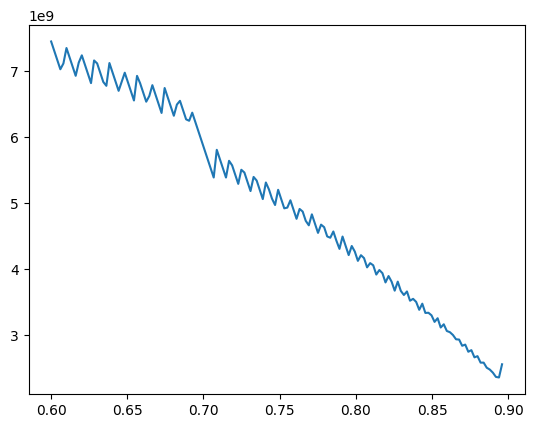

In [267]:
#H = - dz / dlnp = - dz p /dp

bg_variables, info_bg = read_bg("../data/rk2_upw2_pertubation_no_max//background.h5")

dz = (bg_variables['r'] - np.roll(bg_variables['r'], -1))[:-1]
dp = (bg_variables['p0'] - np.roll(bg_variables['p0'], -1))[:-1]
H = - dz / dp * bg_variables['p0'][:-1]

plt.plot(bg_variables['r'][:-1]/R_sun, H)

In [216]:
def print_attrs(name, obj):
    """Print attributes of the HDF5 object."""
    print(name)
    for key, val in obj.attrs.items():
        print(f"  ATTRIBUTE {key}: {val}")

def explore_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        # Print the attributes of the root group
        print_attrs('/', f)

        # Using the visititems method to traverse the file's structure
        f.visititems(print_attrs)

file_path = '../data/rk2_upw2_pertubation_no_max/snap132.h5'
explore_hdf5(file_path)

/
  ATTRIBUTE header: [b'This is the root header']
grid_info
  ATTRIBUTE header: [b'This is the grid data header']
grid_info/dx
  ATTRIBUTE unit: [b'cm']
grid_info/dz
  ATTRIBUTE unit: [b'cm']
grid_info/nx
  ATTRIBUTE unit: [b'Grid points in x']
grid_info/nz
  ATTRIBUTE unit: [b'Grid points in z']
grid_info/nz_full
  ATTRIBUTE unit: [b'Full grid points in z']
grid_info/nz_ghost
  ATTRIBUTE unit: [b'Ghost points in z']
grid_info/t
  ATTRIBUTE unit: [b's']
grid_info/x0
  ATTRIBUTE unit: [b'cm']
grid_info/x1
  ATTRIBUTE unit: [b'cm']
grid_info/z0
  ATTRIBUTE unit: [b'cm']
grid_info/z1
  ATTRIBUTE unit: [b'cm']
variables
  ATTRIBUTE header: [b'This is the variables header']
variables/T1
  ATTRIBUTE unit: [b'K']
variables/p1
  ATTRIBUTE unit: [b'dyn/cm^2']
variables/rho1
  ATTRIBUTE unit: [b'g/cm^3']
variables/s1
  ATTRIBUTE unit: [b'erg/K']
variables/vx
  ATTRIBUTE unit: [b'cm/s']
variables/vz
  ATTRIBUTE unit: [b'cm/s']


In [78]:
def check_dataset(file_path):
    with h5py.File(file_path, 'r') as f:
        print("T1" in f['variables'])

file_path = '../data/save_test/snap0.h5'
check_dataset(file_path)

True


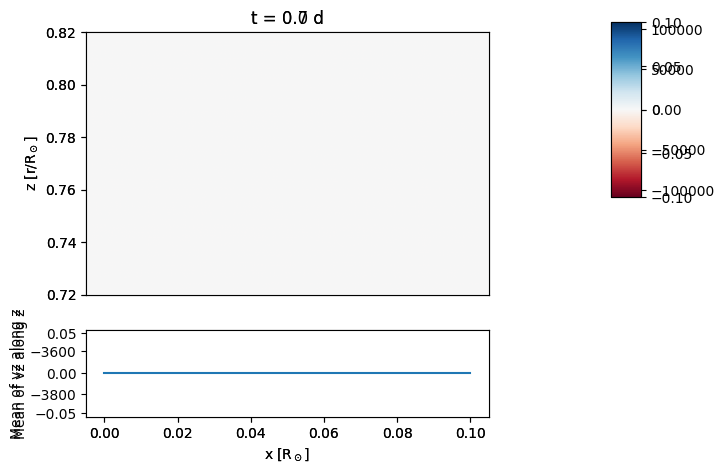

In [3]:
""" ALONG Z-DIRECTION"""

def plot_sod(fig, snap_nr, key):
    variables, info = read_fg("../data/sod_shock_vertical_periodic/snap{}.h5".format(snap_nr))
    t, nx, nz, nz_full, nz_ghost, dx, dz, z0, z1, x0, x1 = info['t'], info['nx'], info['nz'], info['nz_full'], info['nz_ghost'], info['dx'], info['dz'], info['z0'], info['z1'], info['x0'], info['x1']
    
    t = (t*u.s).to('day')

    x = np.linspace(x0, x1, nx)
    extent=np.array([x0,x1,z0,z1])/R_sun

    var = variables[key]
    var_mean = np.mean(var, axis=0)

    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_ylabel('z [r/R$_\odot$]')
    ax1.set_xticks([])
    ax1.set_title("t = {:.1f}".format(t))  # Format time to one decimal places
    cax = ax1.imshow(var, aspect='auto', origin='lower', cmap='RdBu', extent=extent)

    cbar_ax = fig.add_subplot(gs[0, 1])
    # Adjust the position of the colorbar axes to move it closer to the main plot
    cbar_ax.set_position([1, 0.55, 0.05, 0.35])  # you might need to adjust these numbers
    fig.colorbar(cax, cax=cbar_ax)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(x/R_sun,var_mean)
    ax2.set_xlabel('x [R$_\odot$]')
    ax2.set_ylabel('Mean of {} along z'.format(key))

    #variables, info = read_fg("../data/periodic_rk2_upw1_sod_horizontal/snap20.h5")
    #var_mean = np.mean(variables[key], axis=0)
    #ax2.plot(x/R_sun,var_mean, color="black", linestyle="--")

fig = plt.figure(figsize=(6, 5))
key = 'vz'

def init_animation():
    plot_sod(fig, 0, key)

def update_animation(snap_nr):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_sod(fig, snap_nr, key)  # Plot the new snapshot

save_name = "sod_vertical_vz.mp4"

anim = FuncAnimation(fig, update_animation, interval=250, frames=range(0,57), init_func=init_animation)
anim.save(save_name, writer='ffmpeg', fps=20, extra_args=['-vcodec', 'libx264'])
#HTML(anim.to_html5_video())



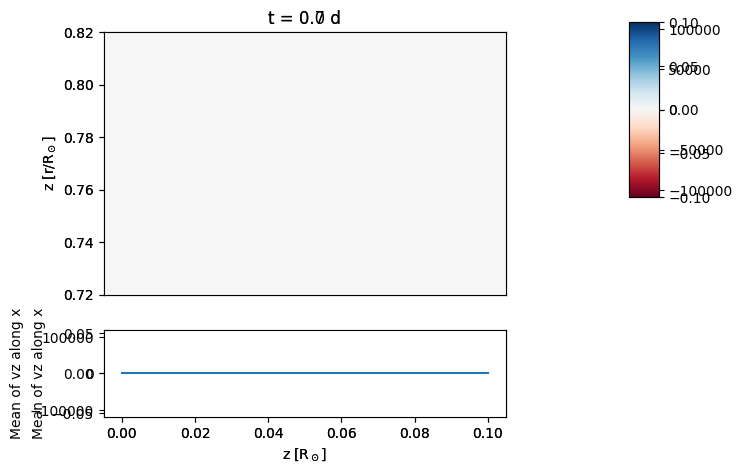

In [8]:
""" ALONG X-DIRECTION """

def plot_sod(fig, snap_nr, key):
    variables, info = read_fg("../data/sod_shock_vertical_periodic/snap{}.h5".format(snap_nr))
    t, nx, nz, nz_full, nz_ghost, dx, dz, z0, z1, x0, x1 = info['t'], info['nx'], info['nz'], info['nz_full'], info['nz_ghost'], info['dx'], info['dz'], info['z0'], info['z1'], info['x0'], info['x1']
    
    t = (t*u.s).to('day')

    x = np.linspace(x0, x1, nx)
    extent=np.array([x0,x1,z0,z1])/R_sun

    var = variables[key]
    var_mean = np.mean(var[2:-2], axis=1)

    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_ylabel('z [r/R$_\odot$]')
    ax1.set_xticks([])
    ax1.set_title("t = {:.1f}".format(t))  # Format time to one decimal places
    cax = ax1.imshow(var, aspect='auto', origin='lower', cmap='RdBu', extent=extent)

    cbar_ax = fig.add_subplot(gs[0, 1])
    # Adjust the position of the colorbar axes to move it closer to the main plot
    cbar_ax.set_position([1, 0.55, 0.05, 0.35])  # you might need to adjust these numbers
    fig.colorbar(cax, cax=cbar_ax)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(x/R_sun,var_mean)
    ax2.set_xlabel('z [R$_\odot$]')
    ax2.set_ylabel('Mean of {} along x'.format(key))

    #variables, info = read_fg("../data/periodic_rk2_upw1_sod_horizontal/snap20.h5")
    #var_mean = np.mean(variables[key], axis=0)
    #ax2.plot(x/R_sun,var_mean, color="black", linestyle="--")

fig = plt.figure(figsize=(6, 5))
key = 'vz'

def init_animation():
    plot_sod(fig, 0, key)

def update_animation(snap_nr):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_sod(fig, snap_nr, key)  # Plot the new snapshot

save_name = "sod_vertical_vz.mp4"

anim = FuncAnimation(fig, update_animation, interval=250, frames=range(0,57), init_func=init_animation)
anim.save(save_name, writer='ffmpeg', fps=20, extra_args=['-vcodec', 'libx264'])
#HTML(anim.to_html5_video())


In [2]:
def read_mpi_info(file_path):
    with h5py.File(file_path, 'r') as f:
        n_procs = f['/total_processes'][()]
    return n_procs

In [31]:
def get_total_var(snap, var_name, n_procs, folder):
    variables = []

    for i in range(n_procs):
        variable, info = read_fg("{}snap{}_{}.h5".format(folder,snap, i))
        variables.append(variable)

    t = info['t']


    total_var_list = []
    for i in range(n_procs):
        if i == 0:
            total_var_list.append(variables[i][var_name][:-2])
        elif i == n_procs - 1:
            total_var_list.append(variables[i][var_name][2:])
        else:
            total_var_list.append(variables[i][var_name][2:-2])
    total_var = np.concatenate(total_var_list, axis=0)
    
    return total_var, t

In [28]:
print(total_var.shape)

(104, 100)


(104, 100)


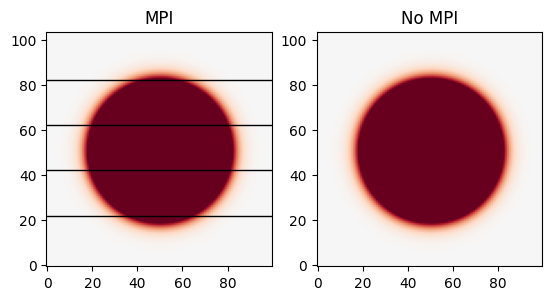

In [201]:
var_name = "p1"

folder_mpi = "../data/mpi_on/"
folder_no_mpi = "../data/mpi_off/"

vmax = 1e5

num_files = 40
interval = 1

n_procs = read_mpi_info("{}mpi_info.h5".format(folder_mpi))

# Initialize the plot
fig, ax = plt.subplots(1, 2)
variable, t = get_total_var(0, var_name, n_procs, folder_mpi)
print(variable.shape)
cax0 = ax[0].imshow(variable, origin='lower', cmap="RdBu", vmin=-vmax, vmax=vmax)
#cbar = plt.colorbar(cax)

variables, info = read_fg("{}snap{}.h5".format(folder_no_mpi, 0))


cax1 = ax[1].imshow(variables[var_name], origin='lower', cmap="RdBu", vmin=-vmax, vmax=vmax)

#cbar1 = fig.colorbar(cax0, ax=ax[0], shrink=0.6)
#cbar2 = fig.colorbar(cax1, ax=ax[1], shrink=0.6)

# The update function for animation
def update(frame):
    ax[0].clear()
    ax[1].clear()
    variable, t = get_total_var(frame, var_name, n_procs, folder_mpi)
    cax0 = ax[0].imshow(variable, origin='lower', cmap="RdBu", vmin=-vmax, vmax=vmax)
    ax[0].set_title('MPI')
    ax[0].axhline(y=22, color='black', linewidth=1)
    ax[0].axhline(y=42, color='black', linewidth=1)
    ax[0].axhline(y=62, color='black', linewidth=1)
    ax[0].axhline(y=82, color='black', linewidth=1)

    variables, info = read_fg("{}snap{}.h5".format(folder_no_mpi, frame))
    cax1 = ax[1].imshow(variables[var_name], origin='lower', cmap="RdBu", vmin=-vmax, vmax=vmax)
    ax[1].set_title('No MPI')
    

# Animate
ani = animation.FuncAnimation(fig, update, frames=range(0,num_files, interval), repeat=False)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('animation.mp4', writer=writer)